## Exercise: Sound detection and localisation
Implementation of an algorithm to detect and localise 2 sound events within a 3-channel audio file recorded by 3 sample-synchronized microphones in a known configuration. Event detections are computed using a simple energy threshold metric. Event locations are estimated using TDOA derived from the generalized cross-correlation phase transform (GCC-PHAT), computed over a single static event frame. See README for additional notes and references.

Gershon Dublon, 2021-09-18

In [22]:
import numpy as np
import soundfile as sf
from scipy.optimize import fsolve

%matplotlib inline 
import matplotlib.pyplot as plt

In [23]:
# read wav files
evaluation_recording, fs = sf.read('resources/evaluation-recording.wav')
test_recording, fs = sf.read('resources/test-recording.wav')
target, fs = sf.read('resources/target.wav')

In [24]:
# set the scene 

# choose which recording to use from the cell above
recording = evaluation_recording

# speed of sound at 25c
c = 346.3

# microphone positions (ordered)
mics = [(-0.5, 0), (0, 0), (0.5, 0)]

# assignment of microphones as reference or measurement, can be swapped around
# assignments index into the microphone positions array above
ref = 1
m1 = 0
m2 = 2

In [25]:
# simple function to detect event onsets in a mono audio recording
# slides non-overlapping windows of window_length over the recording
# computes a ratio of the energy in a given frequency band to total energy
# if the ratio exceeds a hard threshold, records an onset and jumps forward 2 window_lengths (ignores brief pauses)
# will not record another onset until envelope is marked complete
def pseudo_vad(recording, fs=44100, window_length=11025, f_low=100, f_high=3000, detection_threshold=0.5):
    recording_length = recording.shape[0]
    
    # frequency band of interest
    freqs = np.fft.fftfreq(window_length, 1/fs)
    activebands = np.where(np.logical_and(freqs>=f_low, freqs<=f_high))[0]

    detections = []
    detection_in_progress = False
    window_start = 0
    while (window_start < (recording_length - window_length)):
        # assumes mono audio
        sig = recording[window_start:window_start + window_length]
        sig_fft = np.abs(np.fft.rfft(sig, n=window_length))

        ratio = np.sum(sig_fft[activebands])/np.sum(sig_fft)
        if(ratio>detection_threshold):
            if not detection_in_progress:
                detections.append([window_start,window_start]) # record onset, begin looking for end
                detection_in_progress = True
            window_start = window_start + 2*window_length # jump forward by 2 windows
            # close out cases where a detection is ongoing near the end of the recording:
            if(window_start > recording_length - window_length):
                detections[len(detections)-1][1]=recording_length
                detection_in_progress = False
        else:
            if detection_in_progress:
                detections[len(detections)-1][1]=window_start # record end as 1 window back
                detection_in_progress = False
            window_start = window_start + window_length

    return np.array(detections)

In [26]:
# computes the generalized cross-correlation phase transform (GCC-PHAT)
# to return the offset (in seconds) between correlated signals sig and sigref
def gcc_phat(sig, sigref, fs):    
    # FFT length
    n = sig.shape[0] + sigref.shape[0]
    
    # FTT input signals
    sig_fft = np.fft.rfft(sig, n=n)
    sigref_fft = np.fft.rfft(sigref, n=n)
    
    # GCC-PHAT core
    p = sig_fft * np.conj(sigref_fft)
    phat = p / np.abs(p)
    rphat = np.fft.irfft(phat, n=n)
    
    # we will consider offsets over the entire input frame valid
    # someday we may want to limit this to a plausible range
    max_offset = int(n / 2)
    rphat = np.concatenate((rphat[-max_offset:], rphat[:max_offset]))
    
    # works for the example, but garbage in = garbage out here
    # in the future, we may want to look into the underlying gcc data
    offset = np.argmax(np.abs(rphat)) - max_offset
    
    # convert offset from samples to seconds
    tau = offset / fs
    
    return tau

In [27]:
# system of equations to be solved in order to find the intersection of two hyperbolas
def hypers(est_pos, *args):
    tau_m1, tau_m2, c, mics, m1, m2, ref = args
    x = est_pos[0]
    y = est_pos[1]
    
    r_ref = (mics[ref][0]-x)**2 + (mics[m1][1]-y)**2
    r_m1 = (mics[m1][0] - x)**2 + (mics[m1][1] - y)**2
    r_m2 = (mics[m2][0] - x)**2 + (mics[m2][1] - y)**2
    deltr_m1 = c*tau_m1
    deltr_m2 = c*tau_m2
    
    F = np.empty((2))
    F[0] = deltr_m1**2 + 2*deltr_m1*np.sqrt(r_ref) + r_ref - r_m1
    F[1] = deltr_m2**2 + 2*deltr_m2*np.sqrt(r_ref) + r_ref - r_m2
    return F

Event 1 detected at time 1.5s, estimated location (-0.6, 0.6) meters
Event 2 detected at time 8.0s, estimated location (0.5, 1.6) meters


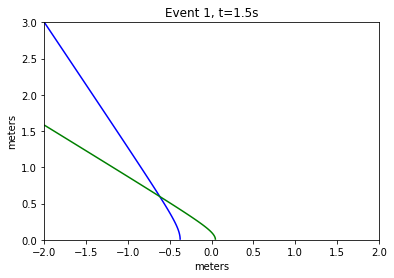

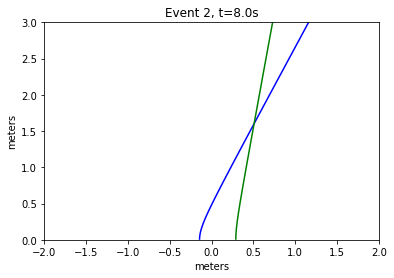

In [28]:
# run event detection on the given recording
detections = pseudo_vad(recording[:,1], fs=44100, window_length=11025, f_low=100, f_high=3000, detection_threshold=0.5)

# notebook only: plotting code and terms
x = np.linspace(-2, 2, 400)
y = np.linspace(0, 3, 400) # given: everything is in front of the array
x, y = np.meshgrid(x, y)
r_ref = (mics[ref][0]-x)**2 + (mics[m1][1]-y)**2
r_m1 = (mics[m1][0] - x)**2 + (mics[m1][1] - y)**2
r_m2 = (mics[m2][0] - x)**2 + (mics[m2][1] - y)**2

event_count = 0
for det in detections:
    event_count = event_count + 1
    tau_m1 = gcc_phat(recording[det[0]:det[1],m1],recording[det[0]:det[1],ref], fs)
    tau_m2 = gcc_phat(recording[det[0]:det[1],m2],recording[det[0]:det[1],ref], fs)
    
    # notebook only: plotting code and terms
    deltr_m1 = c*tau_m1
    deltr_m2 = c*tau_m2
    plt.figure()
    plt.contour(x , y, 
            deltr_m1**2 + 2*deltr_m1*np.sqrt(r_ref) + r_ref - r_m1,
            [0],
            colors='b')
    plt.contour(x , y, 
            deltr_m2**2 + 2*deltr_m2*np.sqrt(r_ref) + r_ref - r_m2,
            [0],
            colors='g')
    plt.xlabel('meters')
    plt.ylabel('meters')
    plt.title('Event {}, t={}s'.format(event_count, det[0]/fs))
    
    guess = np.array([1,1])
    args = (tau_m1, tau_m2, c, mics, m1, m2, ref)
    est_loc = fsolve(hypers, guess, args=args)
    est_loc = np.around(est_loc, 1)
    print('Event {} detected at time {}s, estimated location ({}, {}) meters'.format(event_count, det[0]/fs, est_loc[0], est_loc[1]))
    